<small>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, FaMAF UNC, 2021.</small>
# Introducción al Aprendizaje automático 

Este trabajo pertenece a la mentoría **GAP: Gestión Automática de Pedidos de Combustibles Líquidos basada en telemetría de inventarios**.

Integrantes:
- Bernaschini, María Laura
- Bosch, Daniela
- Sanabria, Ángel

## Introducción

Luego de haber generado nuestro nuevo conjunto de datos con información curada y procesada comenzamos a realizar algunas predicciones sobre el mismo.  

La predicción se hará **sobre el acumulado de consumos durante un periodo de tiempo `consumo_accum`.** Si bien el objetivo del proyecto es lograr predecir el momento en que un centro operativo se queda sin combustible, con estas predicciones nos vamos acercando al objetivo final.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import seaborn as sns
import datetime as dt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

seaborn.set_context('talk')
# Set float format
pd.set_option('display.float_format','{:.2f}'.format)
pd.set_option('mode.chained_assignment', None)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel')
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

## Lectura del dataset procesado

Levantamos el archivo pickle generado en el trabajo anterior con los datos ya curados.

In [ ]:
def connect_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    return GoogleDrive(gauth)

def read_pkl_from_drive(drive, id, filename):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_pickle(filename)

def read_csv_from_drive(drive, id, filename, usecols, parse_dates, dtypes):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(filename)  
    return pd.read_csv(
        filename, 
        dtype=dtypes, 
        parse_dates=parse_dates,
        usecols=usecols
    )

drive = connect_to_drive()

In [ ]:
pkl_key = '1SztUxzHZjf1mmNRC77KmJ2p33urOxibT'
curated_pkl = read_pkl_from_drive(drive, pkl_key, 'curated_df.pkl')

In [ ]:
curated_pkl

,id_equipo,nombre_producto,equipo_producto,capacidad,industria,volumen_escl,consumo_escl
timestamp,,,,,,,
2021-01-18 17:00:00,159,Formula Diesel,159-Formula Diesel,21327.00,Service Station,0.37,0.00
2021-01-18 18:00:00,159,Formula Diesel,159-Formula Diesel,21327.00,Service Station,0.37,0.00
2021-01-18 19:00:00,159,Formula Diesel,159-Formula Diesel,21327.00,Service Station,0.37,0.00
2021-01-18 20:00:00,159,Formula Diesel,159-Formula Diesel,21327.00,Service Station,0.37,0.00
2021-01-18 21:00:00,159,Formula Diesel,159-Formula Diesel,21327.00,Service Station,0.37,0.00
...,...,...,...,...,...,...,...
2021-02-26 13:00:00,959,Producto 1,959-Producto 1,1033.00,Distributor,3.86,0.00
2021-02-26 14:00:00,959,Producto 1,959-Producto 1,1033.00,Distributor,3.86,0.00
2021-02-26 15:00:00,959,Producto 1,959-Producto 1,1033.00,Distributor,3.86,0.00


In [ ]:
# Realizamos una copia para mantener el dataset original.
data = curated_pkl.copy()

## Selección de sitios

Procedemos a seleccionar 5 sitios para la predicción del consumo. Para realizar una predicción más precisa decidimos elegir sitios pertenecientes a una misma industria, en este caso `Service Station`, y que almacenaran un mismo producto `Formula Diesel`, ya que el nivel de consumo varía de acuerdo al tipo de industria y producto que se considere.

In [ ]:
data_filtered=data[data["industria"]=="Service Station"]

In [ ]:
data_filtered.nombre_producto.unique()

array(['Formula Diesel', 'Nafta Super', 'V-Power Diesel', 'V-Power Nafta',
       'D500', 'Infinia Diesel', 'Infinia Nafta', 'Euro Diesel',
       'Formula', 'Super', 'VP-Diesel', 'VP-Nafta', 'Nafta V-Power',
       'V-Power Nitro', 'VP Nafta', 'Diesel 500', 'Product 2', 'Diesel',
       'Quantum Diesel', 'Quantum Nafta', 'Euro', 'Premium', 'VP Diesel'],
      dtype=object)

In [ ]:
data_filtered=data_filtered[data_filtered["nombre_producto"]== "Formula Diesel"]

In [ ]:
data_filtered.id_equipo.unique()

array(['159', '429', '477', '495', '841', '900'], dtype=object)

Existen 6 sitios que poseen tanques con Formula Diesel, por lo que elegimos los 5 sitios que contienen mayor cantidad de observaciones.

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="477"])

2160

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="495"])

2159

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="841"]) ## sitio con menor cantidad de observaciones

1669

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="900"])

2160

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="159"])

1735

In [ ]:
len(data_filtered[data_filtered["id_equipo"]=="429"])

2160

In [ ]:
data_filtered= data_filtered[data_filtered["id_equipo"]!="841"]## eliminamos el sitio con menor cantidad de observaciones

In [ ]:
data_filtered.id_equipo.unique()

array(['159', '429', '477', '495', '900'], dtype=object)

In [ ]:
selected_sites = [
    "159-Formula Diesel",
    "429-Formula Diesel",
    "477-Formula Diesel",
    "495-Formula Diesel",
    "900-Formula Diesel"
]

## Feature engineering

En esta sección se seleccionan los features relevantes y se construyen nuevos features a partir de los atributos. 

Las features construidas fueron:
- `consumo_accum`: Consumo acumulado por sitio - producto.
- `ordinal_datetime`: Debemos tranformar el timestamp a un valor numérico para que puedan ser utilizados por los modelos.

In [ ]:
# Consumos acumulados
data_consumption = data_filtered[['equipo_producto', 'consumo_escl']]
data_consumption = data_consumption.sort_index()
data_consumption.loc[:,'consumo_accum'] = data_consumption.groupby('equipo_producto')['consumo_escl'].transform("cumsum")

# Transformación del datetime a numérico
datetime_range = pd.date_range(start='2021-01-01', end='2021-04-01', closed='left', freq='H')
ordinal_datetime_dict = { k: i for (i, k) in enumerate(datetime_range) }
data_consumption["ordinal_datetime"] = data_consumption.index.map(ordinal_datetime_dict)

data_consumption = data_consumption.dropna()

In [ ]:
data_consumption.head()

,equipo_producto,consumo_escl,consumo_accum,ordinal_datetime
timestamp,,,,
2021-01-01 00:00:00,495-Formula Diesel,0.00,0.00,0
2021-01-01 00:00:00,429-Formula Diesel,0.00,0.00,0
2021-01-01 00:00:00,477-Formula Diesel,0.00,0.00,0
2021-01-01 00:00:00,900-Formula Diesel,0.00,0.00,0
2021-01-01 01:00:00,429-Formula Diesel,0.00,0.00,1


## Modelos

Para la predicción de los consumos se creará **un modelo con centros operativos pertenecientes a una misma industria (Service Station) y a un mismo producto (Formula Diesel)**. Para entrenar y validar el modelo emplearemos las últimas dos semanas del dataset.

### Selección de los modelos

Se probaron distintos modelos regresivos y se eligió el que presentó un mejor ajuste mirando la variación del error cuadrático en la cross-validación.

Para realizar el cross-validation se utiliza la clase `TimeSeriesSplit`.

#### Dividimos el dataset en train y test
Tomamos los primeros 14 días para entrenar el modelo y los últimos 4 para evaluarlo. 

Luego del análisis realizado en los trabajos anteriores, las features elegidas para el entrenamiento fueron:
- `X`: El tiempo de forma ordinal.
- `y`: Los consumos acumulados.

In [ ]:
# Train
X_train = data_consumption['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_consumption.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_consumption['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_consumption.loc['2021-03-28':, 'consumo_accum']

Resultados
LR: -0.0002052869493562426 (0.00023955880573935413)
NN: -8.095974192949829e-05 (0.00015572901239642)
DT: -0.2220276960992374 (0.22480428466478108)
KNN: -0.09695142276235622 (0.11972347030994276)
RF: -0.14001155589780778 (0.16300092026031454)
SVR: -0.2023512194685307 (0.014548081852959792)



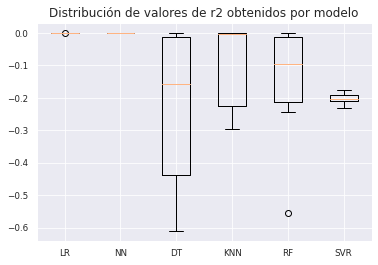

In [ ]:
print('==============================')
print(f'Resultados')
print('==============================')
results = []
models = []
names = []

models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver='lbfgs')))
models.append(('DT', DecisionTreeRegressor())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear# Evaluate each model in turn

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
        
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

print('')
plt.boxplot(results, labels=names)
plt.title("Distribución de valores de r2 obtenidos por modelo")
plt.show() 
print('')

En general, los modelos probados se ajustaron muy mal a los datos ya que el r2 fue muy pequeño, negativo en todos los casos. La regresión lineal fue el mejor modelo (mayor r2) en comparación con los otros. A continuación ajustaremos este modelo a nuestros datos.

### Entrenamiento y ajuste del modelo

Se ajustará el modelo de regresión lineal a los datos por sitio y se obtendrán las predicciones y métricas más relevantes.

In [ ]:
# Para ser graficados más adelante
predictions = {}

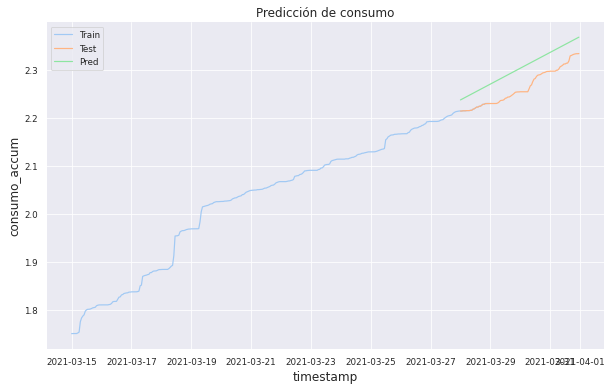

In [ ]:
model = LinearRegression()
data_site_159 = data_consumption[data_consumption["equipo_producto"] == "159-Formula Diesel"]
# Train
X_train = data_site_159['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_site_159.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_site_159['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_site_159.loc['2021-03-28':, 'consumo_accum']

# Predict
model.fit(X_train, y_train)
pred = model.predict(X_test)
y_test_pred = pd.Series(pred, index=y_test.index)
predictions['159-Formula Diesel'] = y_test_pred

# Plot
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=y_train, label='Train').set_title("Predicción de consumo")
sns.lineplot(data=y_test, label='Test')
sns.lineplot(data=y_test_pred, label='Pred')
sns.despine()

In [ ]:
explained_variance=metrics.explained_variance_score(y_test, y_test_pred)
mse=metrics.mean_squared_error(y_test, y_test_pred) 
r2=metrics.r2_score(y_test, y_test_pred)
print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.9611
MSE:  0.0016
r2:  -0.154


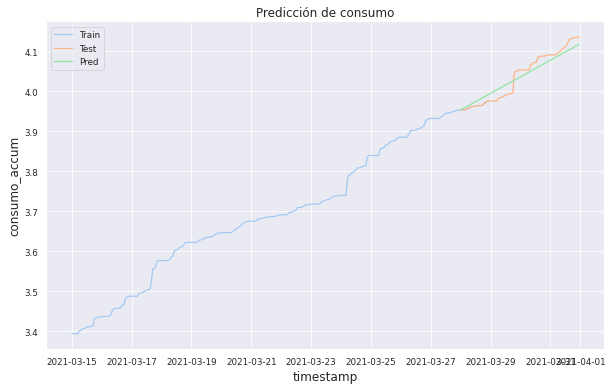

In [ ]:
model = LinearRegression()
data_site_429 = data_consumption[data_consumption["equipo_producto"] == "429-Formula Diesel"]
# Train
X_train = data_site_429['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_site_429.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_site_429['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_site_429.loc['2021-03-28':, 'consumo_accum']

# Predict
model.fit(X_train, y_train)
pred = model.predict(X_test)
y_test_pred = pd.Series(pred, index=y_test.index)
predictions['429-Formula Diesel'] = y_test_pred

# Plot
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=y_train, label='Train').set_title("Predicción de consumo")
sns.lineplot(data=y_test, label='Test')
sns.lineplot(data=y_test_pred, label='Pred')
sns.despine()

In [ ]:
explained_variance=metrics.explained_variance_score(y_test, y_test_pred)
mse=metrics.mean_squared_error(y_test, y_test_pred) 
r2=metrics.r2_score(y_test, y_test_pred)
print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.9162
MSE:  0.0003
r2:  0.9158


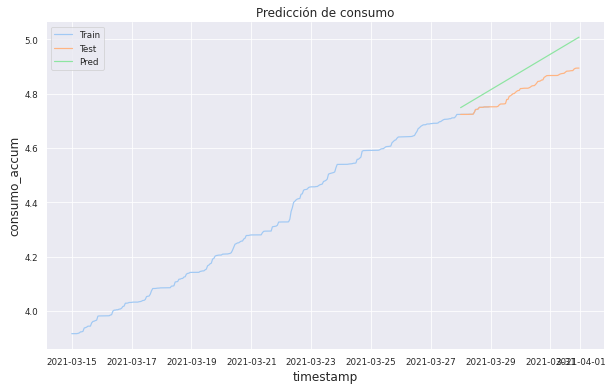

In [ ]:
model = LinearRegression()
data_site_900 = data_consumption[data_consumption["equipo_producto"] == "900-Formula Diesel"]
# Train
X_train = data_site_900['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_site_900.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_site_900['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_site_900.loc['2021-03-28':, 'consumo_accum']

# Predict
model.fit(X_train, y_train)
pred = model.predict(X_test)
y_test_pred = pd.Series(pred, index=y_test.index)
predictions['900-Formula Diesel'] = y_test_pred

# Plot
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=y_train, label='Train').set_title("Predicción de consumo")
sns.lineplot(data=y_test, label='Test')
sns.lineplot(data=y_test_pred, label='Pred')
sns.despine()

In [ ]:
explained_variance=metrics.explained_variance_score(y_test, y_test_pred)
mse=metrics.mean_squared_error(y_test, y_test_pred) 
r2=metrics.r2_score(y_test, y_test_pred)
print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.8668
MSE:  0.0055
r2:  -0.6922


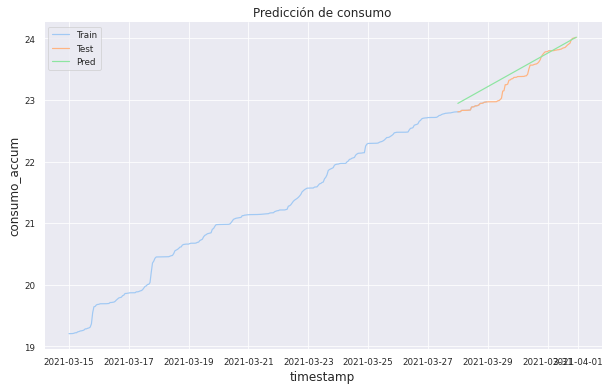

In [ ]:
model = LinearRegression()
data_site_477 = data_consumption[data_consumption["equipo_producto"] == "477-Formula Diesel"]
# Train
X_train = data_site_477['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_site_477.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_site_477['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_site_477.loc['2021-03-28':, 'consumo_accum']

# Predict
model.fit(X_train, y_train)
pred = model.predict(X_test)
y_test_pred = pd.Series(pred, index=y_test.index)
predictions['477-Formula Diesel'] = y_test_pred

# Plot
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=y_train, label='Train').set_title("Predicción de consumo")
sns.lineplot(data=y_test, label='Test')
sns.lineplot(data=y_test_pred, label='Pred')
sns.despine()

In [ ]:
explained_variance=metrics.explained_variance_score(y_test, y_test_pred)
mse=metrics.mean_squared_error(y_test, y_test_pred) 
r2=metrics.r2_score(y_test, y_test_pred)
print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.9358
MSE:  0.0257
r2:  0.836


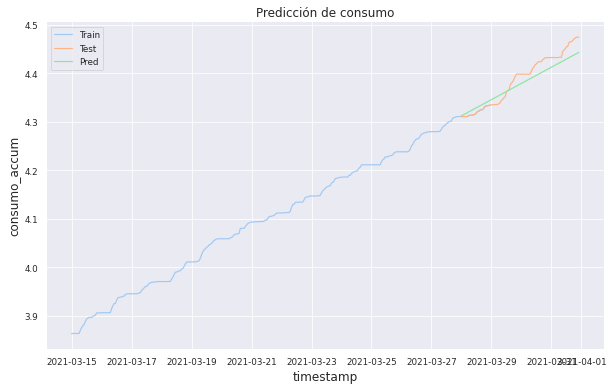

In [ ]:
model = LinearRegression()
data_site_495 = data_consumption[data_consumption["equipo_producto"] == "495-Formula Diesel"]
# Train
X_train = data_site_495['2021-03-15':'2021-03-28']['ordinal_datetime'].values.reshape(-1, 1)
y_train = data_site_495.loc['2021-03-15':'2021-03-28', 'consumo_accum']

# Test
X_test = data_site_495['2021-03-28':]['ordinal_datetime'].values.reshape(-1, 1)
y_test = data_site_495.loc['2021-03-28':, 'consumo_accum']

# Predict
model.fit(X_train, y_train)
pred = model.predict(X_test)
y_test_pred = pd.Series(pred, index=y_test.index)
predictions['495-Formula Diesel'] = y_test_pred

# Plot
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=y_train, label='Train').set_title("Predicción de consumo")
sns.lineplot(data=y_test, label='Test')
sns.lineplot(data=y_test_pred, label='Pred')
sns.despine()

In [ ]:
explained_variance=metrics.explained_variance_score(y_test, y_test_pred)
mse=metrics.mean_squared_error(y_test, y_test_pred) 
r2=metrics.r2_score(y_test, y_test_pred)
print('explained_variance: ', round(explained_variance,4))    
print('MSE: ', round(mse,4))
print('r2: ', round(r2,4))

explained_variance:  0.9075
MSE:  0.0003
r2:  0.881


A partir de los resultados de las métricas para cada sitio, podemos observar que el modelo de regresión lineal se ajusto bien a los datos de los sitios 495, 477 y 429 (r2 > 0.80), mientras que tuvo un ajuste pobre para los equipos 159 y 900 (r2 negativos).

### Evaluación de los modelos

Finalmente comparamos los resultados con el inventario real del centro operativo en el momento predecido.

In [ ]:
# Defino funcion para sacar el volumen
def volumen_pred_fn(row):
    global aux_Reversed_acum
    global aux_volumen_pred
    if row['volumen_pred'] < 0:
      ret = aux_volumen_pred - row['Reversed_acum']
      aux_volumen_pred = ret
      #aux_Reversed_acum = row['Reversed_acum']
      return ret
    else:
      #aux_Reversed_acum = row['Reversed_acum']
      aux_volumen_pred = row['volumen_pred']
      return row['volumen_pred']

Error absoluto: 96.4774953081419 lts.
Error absoluto: 4297.035710836177 lts.
Error absoluto: 10718.454690367744 lts.
Error absoluto: 4279.660533841394 lts.
Error absoluto: 11606.214165963042 lts.


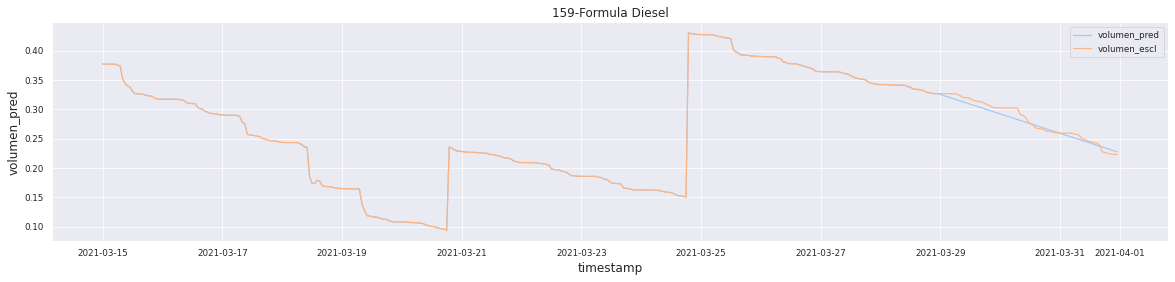

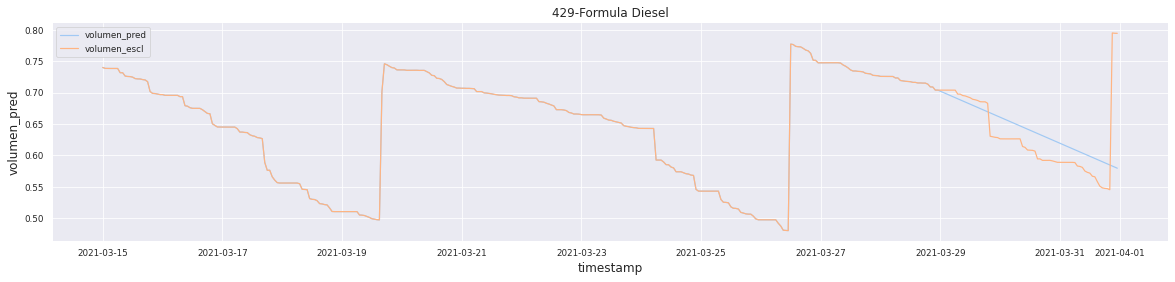

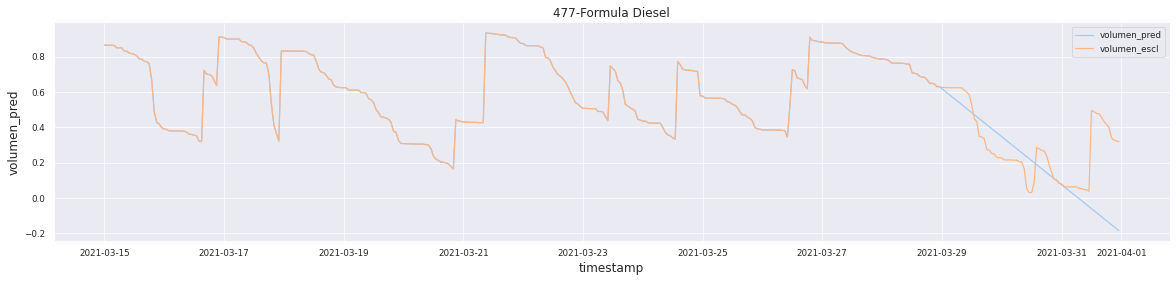

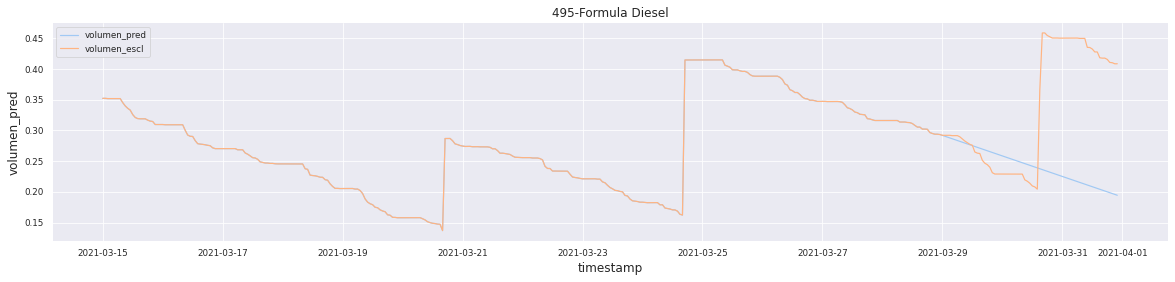

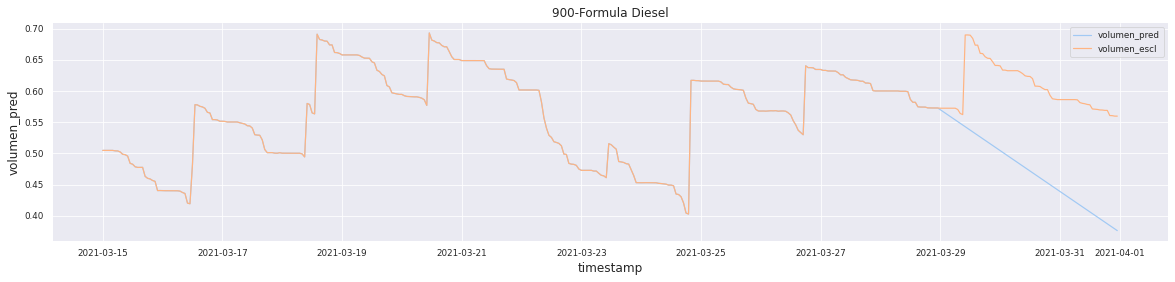

In [ ]:
init_train_date = '2021-03-15'
end_train_date = '2021-03-28'
init_pred_dat = '2021-03-29'
aux_Reversed_acum = 0
aux_volumen_pred = 0

for site in selected_sites:
    data_site = data[data["equipo_producto"] == site]
    df2 = pd.DataFrame()     #Creo df nulo
    df2 = data_site['2021-03-15':].join(predictions[site].to_frame())
    df2.rename(columns={0: "Prediction_acum"}, inplace=True)
    df2['Reversed_acum'] = df2['Prediction_acum'].diff().fillna(df2['Prediction_acum']).astype(float)
    df2.loc['2021-03-15 00:00:00', 'Reversed_acum'] = 0     # primer valor en 0   -- Hacer que no dependa del string con loc o iloc
    df2['volumen_pred'] = df2['volumen_escl']
    df2.loc[init_pred_dat:,'volumen_pred'] = -1             # a los valores de volumen que tengo el resultado de la prediccion los pongo como negativos para modificarlos despues
    df2["volumen_pred"] = df2.apply(volumen_pred_fn, axis=1)        ## Si es volumen positivo devuelve el valor que tiene, en los negativos los modificamos en funcion de Reversed_acum (que esta en funcion del y_pred)
    aux_Reversed_acum = 0
    aux_volumen_pred = 0

    error_abs = abs(df2.iloc[-1]['volumen_pred'] - df2.iloc[-1]['volumen_escl']) * df2.iloc[0]['capacidad']
    print(f"Error absoluto: {error_abs} lts.")

    #fig = plt.figure(figsize=(20, 4))
    #seaborn.lineplot(data=df2.Reversed_acum, label='Reversed_acum').set_title(site)
    #seaborn.lineplot(data=df2.consumo_escl, label='consumo_escl')
    #seaborn.despine()

    fig = plt.figure(figsize=(20, 4))
    seaborn.lineplot(data=df2.volumen_pred, label='volumen_pred').set_title(site)
    seaborn.lineplot(data=df2.volumen_escl, label='volumen_escl')
    seaborn.despine()

## Conclusiones

Se puede observar que mientras no ocurran abastecimientos durante el periodo predicho, el ajuste resulta bastante acorde.

Luego de entrenar los modelos, además, vemos la necesidad de incorporar nuevos features para mejorar la predicción, principalmente aquellas que indiquen la estacionalidad de los datos (ej: fines de semana, días feriados, vacaciones) realizando un análisis previo de descomposición de series temporales. Además, observamos que el mejor modelo se ajustó bien a algunos de los sitios pero no así a otros. Estos hallazgos sugieren la necesidad de entrenar modelos para cada sitio, sin embargo esto podría generar un gasto computacional importante. Por último, sería importante entrenar modelos más acordes a datos temporales tales como ARIMA, Simple Exponential smoothing, Holt-Winters exponential smoothing, etc.